In [1]:
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorSampler, StatevectorEstimator
from qiskit.visualization import plot_histogram

from scipy.optimize import minimize

import pandas as pd
import numpy as np

<img src="../images/stock_prices.png" alt="Alt text" width="500" height="300">

In [2]:
assets =  ['BRKM5.SA', 'ITUB4.SA', 'VALE3.SA', 'KLBN4.SA']

expected_value = [0.335649, 0.084554, 0.357477, 0.148336]
cov_matrix = pd.DataFrame([
    [0.001077, 0.000257,0.000320,0.000190],
    [0.000257,	0.000441,0.000228,0.000084],
    [0.000320,	0.000228, 0.000867,0.000154],
    [0.000190,	0.000084,0.000154,0.000420]
])

n_assets = len(expected_value)

We define a cost function $C$ that we aim to minimize in order to determine the optimal portfolio of assets. The input to this function is a binary vector $x$, where an asset $i$ is included in the portfolio if and only if $x_i=1$. Structuring the problem this way transforms it into a QUBO (Quadratic Unconstrained Binary Optimization) problem.

Below, we present an analytical derivation of the Hamiltonian that represents this QUBO problem, establishing a correspondence between the QUBO formulation and the Ising model. This derivation provides the foundation for implementing the *f_wheight* function defined below, simplifying its definition and computation.

## Variables and Parameters:
- $r$: The expected return for each asset, represented by the variable *expected_value* computed above.
- $C$: The covariance matrix of asset returns, represented by the variable *covariance_matrix* computed above.
- $q$: The risk factor, balancing the trade-off between risk and return.
- $B$ The constraint on the total number of assets in the optimal portfolio.
- $\lambda$: A regularization parameter enforcing the constraint on the portfolio size.

## Cost function
The cost function is given by:
$$
C(x) = -\sum_i r_i x_i + q \sum_{i>j} C_{ij} x_i x_j + \lambda (B - \sum_i x_i)^2
$$

## Calculations

$\lambda (B - \sum_i x_i)^2 = \lambda B^2 - 2\lambda B \sum_i x_i + \lambda \sum_i x_i^2 + 2\lambda \sum_{i>j} x_ix_j$

Since $x_i \in \{0,1\}$, $x_i^2=x_i$, then:

$\lambda (B - \sum_i x_i)^2 = \lambda B^2 - \lambda (2B - 1) \sum_i x_i + 2\lambda \sum_{i>j} x_ix_j$

$$
C(x) = -\sum_i [r_i + \lambda (2B-1)]x_i + \sum_{i>j} (q C_{ij} + 2\lambda)x_ix_j + \lambda B^2
$$

Let defines the following variables for simplification:
- $\beta_i = r_i + \lambda (2B-1)$
- $\gamma_{ij} = q C_{ij} + 2\lambda$

$$
C(x) = -\sum_i \beta_i x_i + \sum_{i>j} \gamma_{ij} x_ix_j + \lambda B^2
$$

To map the coust function $C$ to Hamiltonian formulation $H$, we transform $x_i \to (I-Z_i)/2$, which implies $x_ix_j \to (I-Z_i-Z_j+Z_iZ_j)/4$.

$$
H = \sum_i \left(\dfrac{\beta_i}{2}-\dfrac{1}{4}\sum_{j \neq i}\gamma_{ij}\right)Z_i + \sum_{i>j}\dfrac{\gamma_{ij}}{4}Z_iZ_j + \text{const}
$$

We can discard the $\text{const}$ therm, because this does not change the ground state of the Hamiltonian.

$\dfrac{\beta_i}{2}-\dfrac{1}{4}\sum_{j \neq i}\gamma_{ij} = \dfrac{r_i}{2} + \lambda(B-n/2) - \dfrac{q}{4}\sum_{j \neq i}C_{ij}$

Here, $n$ is defined as the number of assets.

We can multiply the Hamiltonian by a constant, because this does not change the ground state.

$$
H = \sum_i \left[2r_i + 2\lambda(2B-n)-q\sum_{j}C_{ij} \right]Z_i + \sum_{i>j}(qC_{ij}+2\lambda)Z_iZ_j
$$

In [3]:
q = 0.5
B = 2
lamb = 1

In [4]:
def cost_hamiltonian_wheight(i, j=None):
    """
    Calculate the weights for the Hamiltonian of the QUBO problem.

    Args:
        i (int): Index of the first asset.
        j (int, optional): Index of the second asset. Defaults to None.
        
    Returns:
        float: The weight that multiplies the product of the Z operators, acting on qubits i and j.
    """

    if j is None:
        response =2*expected_value[i]+2*lamb*(2*B-n_assets)-q*cov_matrix[i].sum()
    else:
        response = q*cov_matrix[i][j]+2*lamb
    return response

In [5]:
qc = QuantumCircuit(n_assets, n_assets)

for qubit in range(n_assets):
    qc.h(qubit)
qc.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=4, num_clbits=0, params=[]), qubits=(<Qubit register=(4, "q"), index=0>, <Qubit register=(4, "q"), index=1>, <Qubit register=(4, "q"), index=2>, <Qubit register=(4, "q"), index=3>), clbits=())

In [6]:
def add_layer(qc, gamma, beta):
    """
    Adds one QAOA layer to the circuit.
    
    This layer applies:
        - Cost Hamiltonian: exp(-i*gamma*H_c) using CNOT and RZ gates.
        - Mixing Hamiltonian: exp(-i*beta*H_B) using RX gates.
    
    Args:
        gamma (float): Parameter for the cost Hamiltonian.
        beta (float): Parameter for the mixing Hamiltonian.
    """
    
    q_graph = [(i, j) for i in range(n_assets) for j in range(i+1, n_assets)]
    
    # Implement exp(-i*gamma*H_c)
    # H_c: Cost Hamiltonian
    for e in q_graph:
        qc.cx(e[0], e[1])
        qc.rz(2*gamma*cost_hamiltonian_wheight(e[0], e[1]), e[1])
        qc.cx(e[0], e[1])
    for qubit in range(n_assets):
        qc.rz(2*gamma*cost_hamiltonian_wheight(qubit), qubit)
    qc.barrier()
            
    # Implement exp(-i*beta*H_B)
    for qubit in range(n_assets):
        qc.rx(2*beta, qubit)
    qc.barrier()

In [7]:
add_layer(qc,2,3)

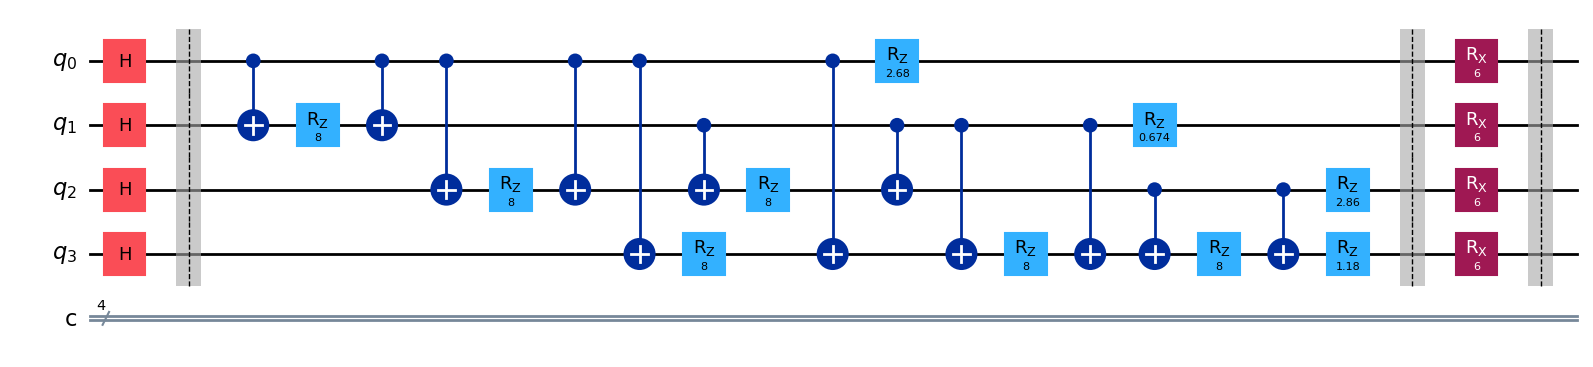

In [8]:
qc.draw("mpl")

In [9]:
H_C = SparsePauliOp.from_list([("ZIII", cost_hamiltonian_wheight(0)), 
                               ("IZII", cost_hamiltonian_wheight(1)),
                               ("IIZI", cost_hamiltonian_wheight(2)),
                               ("IIIZ", cost_hamiltonian_wheight(3)),
                               ("ZZII", cost_hamiltonian_wheight(0,1)),
                               ("ZIZI", cost_hamiltonian_wheight(0,2)),
                               ("ZIIZ", cost_hamiltonian_wheight(0,3)),
                               ("IZZI", cost_hamiltonian_wheight(1,2)),
                               ("IZIZ", cost_hamiltonian_wheight(1,3)),
                               ("IIZZ", cost_hamiltonian_wheight(2,3)),
                              ]
                              )
H_C

SparsePauliOp(['ZIII', 'IZII', 'IIZI', 'IIIZ', 'ZZII', 'ZIZI', 'ZIIZ', 'IZZI', 'IZIZ', 'IIZZ'],
              coeffs=[0.670376 +0.j, 0.168603 +0.j, 0.7141695+0.j, 0.296248 +0.j, 2.0001285+0.j,
 2.00016  +0.j, 2.000095 +0.j, 2.000114 +0.j, 2.000042 +0.j, 2.000077 +0.j])

## Execution

In [10]:
depth = 20
initial_params = []
for _ in range(depth):
    gamma = np.random.uniform(0, 2*np.pi)
    beta = np.random.uniform(0, 2*np.pi)
    initial_params.append(gamma)
    initial_params.append(beta)

In [11]:
estimator = StatevectorEstimator()
def objective(params):
    gamma = params[:depth]
    beta = params[depth:]
    qc = QuantumCircuit(n_assets, n_assets)
    for qubit in range(n_assets):
        qc.h(qubit)
    for i in range(depth):
        add_layer(qc, gamma[i], beta[i])

    job = estimator.run([(qc, H_C)], precision=1e-3)
    result = job.result()
    energy = result[0].data.evs
    return energy

In [12]:
result_qaoa = minimize(objective, initial_params, method='COBYLA')

gamma = result_qaoa.x[:depth]
beta = result_qaoa.x[depth:]

In [13]:
qc = QuantumCircuit(n_assets, n_assets)
for qubit in range(n_assets):
    qc.h(qubit)
for i in range(depth):
    add_layer(qc, gamma[i], beta[i])

qc.measure_all()

In [14]:
sampler = StatevectorSampler()
job = sampler.run([qc], shots=1024)
result = job.result()
counts = result[0].data['meas'].get_counts()

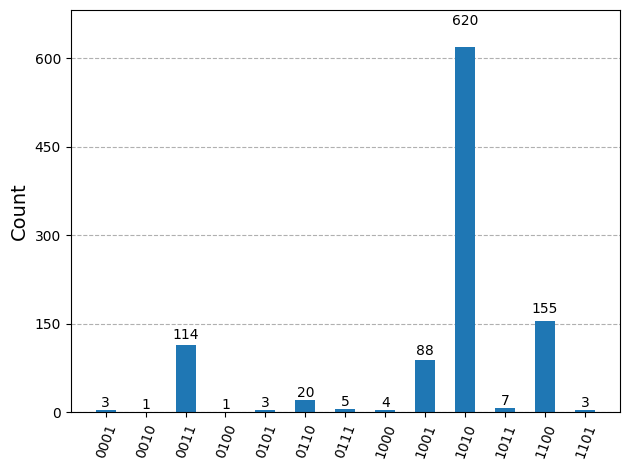

In [15]:
plot_histogram(counts)

In [ ]:
opt_state = max(counts, key=counts.get)
portfolio = [assets[i] for i in range(n_assets) if opt_state[i]=='1']
print(f"Ground State energy (QAOA): {result_qaoa.fun:.2f}, Solution: {opt_state}, Portfolio: {portfolio}")

Ground State energy (QAOA): -4.46, Solution: 1010, Portfolio: ['BRKM5.SA', 'VALE3.SA']
